# Intent recognition

### Dataset used:
ecommerce-intent.csv

### Steps

- Preprocess and clean the dataset
- tokenization, stopword removal, and lemmatization using NLTK
- Create Word2Vec embeddings to capture semantic meaning in the text
- Create document vectors by averaging Word2Vec embeddings for each word in a document
- Train randomforestclassifier on these document vectors to predict intents
- Incorporate tfidf features to capture important words and improve the model's performance
- Save the trained model

In [ ]:
!python -m spacy download en_core_web_sm

In [1]:
import nltk
import joblib
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = pd.read_csv(
#     "hf://datasets/ikshana-zehntech/ecommerce_intent_recognition/ecommerce_intent.csv")

In [ ]:
# df.to_csv('ecommerce_intent.csv', index=False)

In [ ]:
df = pd.read_csv('ecommerce_intent.csv')
df.head()

,context,response
0,question about cancelling order 2B4FZM0C,"intent: cancel_order, variable name: order_num..."
1,i have a question about cancelling oorder 23W8...,"intent: cancel_order, variable name: order_num..."
2,i need help cancelling puchase B7UX7Q76,"intent: cancel_order, variable name: order_num..."
3,I need to cancel purchase GTY5LI52,"intent: cancel_order, variable name: order_num..."
4,"I cannot afford this order, cancel purchase 2L...","intent: cancel_order, variable name: order_num..."


In [ ]:
df.shape

(27869, 2)

In [ ]:
df.columns

Index(['context', ' response', 'cleaned_text'], dtype='object')

In [4]:
def get_custom_stopwords():
    nltk_stop_words = set(stopwords.words('english'))
    spacy_stop_words = nlp.Defaults.stop_words

    negation_words = {
        'no', 'not', 'nor', 'neither', 'never', 'none',
        "n't", 'cannot', "couldn't", "didn't", "doesn't",
        "hadn't", "hasn't", "haven't", "isn't", "mightn't",
        "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
        "weren't", "won't", "wouldn't"
    }

    combined_stopwords = nltk_stop_words.union(spacy_stop_words)
    custom_stopwords = combined_stopwords - negation_words
    return custom_stopwords


custom_stopwords = get_custom_stopwords()
print(custom_stopwords)

{'we', '’re', 'nevertheless', 'be', 'just', 'afterwards', 'thru', 'into', 'become', 'several', 'five', 'against', 'enough', 'down', 'seem', 'this', 'who', 'couldn', 'via', 'thence', 'again', 'will', 'll', 'wouldn', 'say', 'thus', 'four', 'hereafter', "don't", 'alone', 'hereupon', 'at', 'meanwhile', 'anywhere', 'me', 'n’t', 'than', 'themselves', 'very', 'side', 'herein', 'indeed', 'that', 't', 'but', 'a', 'moreover', 'three', 'before', 'see', 'he', 'with', "'ll", '’ll', 'anyway', "'re", 'o', 'own', '‘m', 'during', 'what', 'myself', "aren't", 'whereupon', 'it', 'wherein', 'mustn', 'in', 'all', 'hasn', 'should', 'less', 'does', 'else', 'and', 'had', 'ours', 'much', 'already', 'full', 'itself', 'quite', "'d", 'almost', 'often', 'm', 'must', 'its', 'latterly', 'too', 'hadn', 'now', 'forty', 'am', 'hers', 'towards', 'show', 'whether', 'twelve', 'the', 'after', 'from', "you've", 'our', 'other', 'yet', 'has', 'could', 'well', 'only', 'whole', 'haven', 're', 'seeming', 'keep', 've', 'shan', 'on

In [71]:
def clean_intent_recognition_data(df):
    def clean_context(context):
        # Remove order number or codes
        cleaned_text = re.sub(r'\b[A-Z0-9]{6, }\b', '', context)
        # Remove any remaining special charecters and extra whitespace
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
        return cleaned_text.strip()

    def extract_intent(response):
        intent_match = re.search(r'intent:\s*(\w+)', response)
        return intent_match.group(1) if intent_match else None

    # Clean the context column
    df['cleaned_text'] = df['content'].apply(clean_context)

    # Extract intent from the response column
    df['intent'] = df[' response'].apply(extract_intent)

    # Return only the cleaned text and intent column
    return df[['cleaned_text', 'intent']]


cleaned_df = clean_intent_recognition_data(df)

KeyError: 'content'

In [40]:
df.shape

(27869, 4)

In [ ]:
cleaned_df.sample(10)

,cleaned_text,intent
25917,I am trying to find information about a forgot...,recover_password
2069,modifying details on pro account,edit_account
21403,do ya deliver to India,delivery_options
24078,where can i check the bloody eta of order,track_order
19044,i have problems with opening a freemium account,create_account
11168,help me to see what payment payment modalities...,check_payment_methods
7452,I need assistance to talk to an operator,contact_human_agent
6850,where to make a customer complaint against ur ...,complaint
11937,where to check what payment payment modalities...,check_payment_methods
12488,I want assistance to notify of problems with a...,registration_problems


In [ ]:
cleaned_df.to_csv('ecommerce_intent_cleaned.csv', index=False)

### Load and preprocess the data

In [5]:
def load_data(file_path):
    return pd.read_csv(file_path)


def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()
              and token not in custom_stopwords
              and len(token) > 2
              ]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens


file_path = 'ecommerce_intent_cleaned.csv'
df = load_data(file_path)
df['processed_text'] = df['cleaned_text'].apply(preprocess_text)

In [6]:
df.sample(10)

,cleaned_text,intent,processed_text
22539,assistance to swap several items of order,change_order,"[assistance, swap, item, order]"
16066,need to subit my new shipping address will uhe...,set_up_shipping_address,"[need, subit, new, shipping, address, uhelp]"
11123,I am trying to list your acceoted payment options,check_payment_methods,"[trying, list, acceoted, payment, option]"
12915,where do I report an issue iwth signup,registration_problems,"[report, issue, iwth, signup]"
3880,I do not know how I can switch to tbe Platinum...,switch_account,"[not, know, switch, tbe, platinum, account]"
2385,editing Platinum account,edit_account,"[editing, platinum, account]"
7517,need help to talk to an operator,contact_human_agent,"[need, help, talk, operator]"
3851,switch to standard account,switch_account,"[switch, standard, account]"
4028,how do I give a quick look at my invoice,check_invoice,"[quick, look, invoice]"
10276,I need assistance to sign up to the newsletter,newsletter_subscription,"[need, assistance, sign, newsletter]"


### Create Word2Vec embeddings:

In [7]:
def create_word2vec_model(sentences, vector_size=100, window=5, min_count=5, workers=4):
    """Create Word2Vec model with optimized parameters"""
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        max_vocab_size=10000
    )
    return model

In [8]:
# Create and train Word2Vec model
word2vec_model = create_word2vec_model(df['processed_text'])

In [9]:
def get_document_embedding(tokens, model, vector_size=100):
    """Get document embedding by averaging word vectors"""
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)

    embeddings = [model.wv[word] for word in valid_tokens]
    return np.mean(embeddings, axis=0)

In [10]:
df['doc_vector'] = df['processed_text'].apply(
    lambda x: get_document_embedding(x, word2vec_model))

In [11]:
df.head()

,cleaned_text,intent,processed_text,doc_vector
0,question about cancelling order,cancel_order,"[question, cancelling, order]","[0.12172755, -0.15994464, 0.084058195, 0.23277..."
1,i have a question about cancelling oorder,cancel_order,"[question, cancelling, oorder]","[0.10925479, -0.27430776, 0.13146523, 0.279030..."
2,i need help cancelling puchase,cancel_order,"[need, help, cancelling, puchase]","[-0.018959783, -0.027813861, 0.031375427, 0.29..."
3,I need to cancel purchase,cancel_order,"[need, cancel, purchase]","[-0.0058619115, -0.14750524, 0.11288494, 0.197..."
4,I cannot afford this order cancel purchase,cancel_order,"[not, afford, order, cancel, purchase]","[0.09722481, -0.15432394, 0.1501028, 0.1664212..."


### Prepare data for training:

In [12]:
df['intent']

0                  cancel_order
1                  cancel_order
2                  cancel_order
3                  cancel_order
4                  cancel_order
                  ...          
27864    check_cancellation_fee
27865    check_cancellation_fee
27866    check_cancellation_fee
27867    check_cancellation_fee
27868    check_cancellation_fee
Name: intent, Length: 27869, dtype: object

In [13]:
unique_intents = df['intent'].unique()
# Create a mapping dictionary before label encoding
intent_label_mapping = {idx: label for idx, label in enumerate(unique_intents)}
print("Intent label mapping:", intent_label_mapping)

X = np.array(df['doc_vector'].tolist())
le = LabelEncoder()
y = le.fit_transform(df['intent'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

Intent label mapping: {0: 'cancel_order', 1: 'change_order', 2: 'edit_account', 3: 'switch_account', 4: 'check_invoice', 5: 'contact_customer_service', 6: 'complaint', 7: 'contact_human_agent', 8: 'delivery_period', 9: 'get_invoice', 10: 'newsletter_subscription', 11: 'check_payment_methods', 12: 'registration_problems', 13: 'payment_issue', 14: 'place_order', 15: 'track_refund', 16: 'set_up_shipping_address', 17: 'get_refund', 18: 'check_refund_policy', 19: 'create_account', 20: 'review', 21: 'delivery_options', 22: 'delete_account', 23: 'track_order', 24: 'recover_password', 25: 'change_shipping_address', 26: 'check_cancellation_fee'}


### Train an XGBoost Forest Classifier:

In [14]:
# Prepare the data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': df['intent'].nunique(),
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # for faster training
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Train XGBoost model
num_rounds = 500
clf = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	train-mlogloss:2.22430	test-mlogloss:2.23495
[10]	train-mlogloss:0.65425	test-mlogloss:0.70912
[20]	train-mlogloss:0.26975	test-mlogloss:0.33460
[30]	train-mlogloss:0.12491	test-mlogloss:0.19223
[40]	train-mlogloss:0.06653	test-mlogloss:0.13393
[50]	train-mlogloss:0.04194	test-mlogloss:0.10866
[60]	train-mlogloss:0.03093	test-mlogloss:0.09721
[70]	train-mlogloss:0.02565	test-mlogloss:0.09177
[80]	train-mlogloss:0.02287	test-mlogloss:0.08895
[90]	train-mlogloss:0.02128	test-mlogloss:0.08781
[100]	train-mlogloss:0.02029	test-mlogloss:0.08713
[110]	train-mlogloss:0.01963	test-mlogloss:0.08650
[120]	train-mlogloss:0.01915	test-mlogloss:0.08656
[124]	train-mlogloss:0.01900	test-mlogloss:0.08666


In [15]:
# Save both the classifier and all necessary components including the mapping
components_to_save = {
    'classifier': clf,
    'label_encoder': le,
    'intent_label_mapping': intent_label_mapping,
    'original_intent_labels': unique_intents
}
joblib.dump(components_to_save, 'xgboost_classifier_model_intent.joblib')
joblib.dump(word2vec_model, 'word2vec_model_intent.joblib')

['word2vec_model_intent.joblib']

### Evaluate the model

                          precision    recall  f1-score   support

            cancel_order       0.98      0.96      0.97       187
            change_order       0.97      0.99      0.98       406
 change_shipping_address       0.98      0.98      0.98       191
  check_cancellation_fee       1.00      0.99      1.00       198
           check_invoice       0.92      0.85      0.89       198
   check_payment_methods       1.00      1.00      1.00       200
     check_refund_policy       0.98      0.99      0.99       200
               complaint       1.00      1.00      1.00       187
contact_customer_service       0.98      1.00      0.99       204
     contact_human_agent       0.99      0.99      0.99       205
          create_account       0.96      0.95      0.96       193
          delete_account       0.94      0.93      0.93       207
        delivery_options       1.00      1.00      1.00       210
         delivery_period       1.00      0.99      0.99       213
         

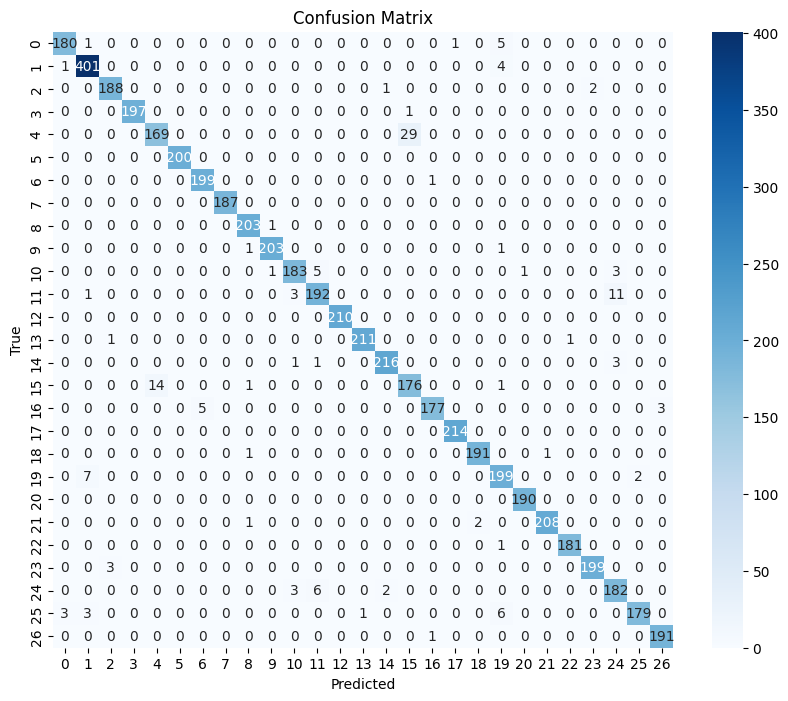

In [16]:
# Predict and evaluate
y_pred = clf.predict(dtest)

# Convert predictions back to original labels for the classification report
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred.astype(int))
print(classification_report(y_test_original, y_pred_original))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Create a function to predict intent for new texts:

In [18]:
def predict_intent(text, word2vec_model, models_dict):
    clf = models_dict['classifier']
    intent_label_mapping = models_dict['intent_label_mapping']

    processed_text = preprocess_text(text)
    embedding = get_document_embedding(processed_text, word2vec_model)
    dpredict = xgb.DMatrix(np.array([embedding]))
    prediction = int(clf.predict(dpredict)[0])

    # Convert numeric prediction to text label using the mapping
    intent_label = intent_label_mapping.get(prediction, "Unknown Intent")
    return intent_label


# Example usage
print("Testing prediction...")
models_dict = joblib.load('xgboost_classifier_model_intent.joblib')
load_word2vec_model = joblib.load('word2vec_model_intent.joblib')

new_text = "I'm having trouble logging into my account. Can you help?"
predicted_intent = predict_intent(new_text, load_word2vec_model, models_dict)
print(f"Predicted intent: {predicted_intent}")

# For debugging
print("\nAvailable intents mapping:")
for idx, label in models_dict['intent_label_mapping'].items():
    print(f"Index {idx}: {label}")

Testing prediction...
Predicted intent: place_order

Available intents mapping:
Index 0: cancel_order
Index 1: change_order
Index 2: edit_account
Index 3: switch_account
Index 4: check_invoice
Index 5: contact_customer_service
Index 6: complaint
Index 7: contact_human_agent
Index 8: delivery_period
Index 9: get_invoice
Index 10: newsletter_subscription
Index 11: check_payment_methods
Index 12: registration_problems
Index 13: payment_issue
Index 14: place_order
Index 15: track_refund
Index 16: set_up_shipping_address
Index 17: get_refund
Index 18: check_refund_policy
Index 19: create_account
Index 20: review
Index 21: delivery_options
Index 22: delete_account
Index 23: track_order
Index 24: recover_password
Index 25: change_shipping_address
Index 26: check_cancellation_fee


### Improve the model with TF-IDF features:

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['cleaned_text'])

X_combined = np.hstack((X, tfidf_features.toarray()))
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42)

dtrain_combined = xgb.DMatrix(X_train_combined, label=y_train)
dtest_combined = xgb.DMatrix(X_test_combined, label=y_test)

# Train XGBoost with combined features
params = {
    'objective': 'multi:softmax',
    'num_class': df['intent'].nunique(),
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'eval_metric': 'mlogloss',
    'random_state': 42
}

clf_combined = xgb.train(
    params,
    dtrain_combined,
    num_rounds,
    evals=[(dtrain_combined, 'train'), (dtest_combined, 'test')],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	train-mlogloss:2.18965	test-mlogloss:2.20904
[10]	train-mlogloss:0.62192	test-mlogloss:0.66565
[20]	train-mlogloss:0.24298	test-mlogloss:0.28658
[30]	train-mlogloss:0.10220	test-mlogloss:0.14257
[40]	train-mlogloss:0.04685	test-mlogloss:0.08503
[50]	train-mlogloss:0.02395	test-mlogloss:0.06030
[60]	train-mlogloss:0.01403	test-mlogloss:0.04941
[70]	train-mlogloss:0.00938	test-mlogloss:0.04400
[80]	train-mlogloss:0.00696	test-mlogloss:0.04082
[90]	train-mlogloss:0.00560	test-mlogloss:0.03926
[100]	train-mlogloss:0.00475	test-mlogloss:0.03827
[110]	train-mlogloss:0.00417	test-mlogloss:0.03784
[120]	train-mlogloss:0.00377	test-mlogloss:0.03753
[130]	train-mlogloss:0.00348	test-mlogloss:0.03747
[140]	train-mlogloss:0.00326	test-mlogloss:0.03744
[142]	train-mlogloss:0.00322	test-mlogloss:0.03746


['intent_recognition_components.joblib']

In [23]:
# Save all necessary components
components_to_save = {
    'classifier': clf_combined,
    'label_encoder': le,
    'tfidf_vectorizer': tfidf_vectorizer,
    'word2vec_model': word2vec_model,
    'intent_label_mapping': models_dict['intent_label_mapping']
}
joblib.dump(components_to_save, 'intent_recognition_components.joblib')

['intent_recognition_components.joblib']

In [20]:
def predict_intent(text, components):
    # Extract components
    clf = components['classifier']
    label_encoder = components['label_encoder']
    word2vec_model = components['word2vec_model']
    tfidf_vectorizer = components['tfidf_vectorizer']

    # Process text
    processed_text = preprocess_text(text)

    # Get Word2Vec embedding
    w2v_embedding = get_document_embedding(processed_text, word2vec_model)

    # Get TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([text]).toarray()

    # Combine features
    combined_features = np.hstack((w2v_embedding, tfidf_features[0]))

    # Create DMatrix and predict
    dpredict = xgb.DMatrix(np.array([combined_features]))
    prediction_idx = int(clf.predict(dpredict)[0])

    # Convert to original label
    intent_label = label_encoder.inverse_transform([prediction_idx])[0]

    return intent_label


# Example usage
components = joblib.load('intent_recognition_components.joblib')
new_text = "I'm having trouble logging into my account. Can you help me?"
predicted_intent = predict_intent(new_text, components)
print(f"Predicted intent: {predicted_intent}")

Predicted intent: edit_account
